In [1]:
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
pd.set_option('display.max_columns', 500)
from IPython.display import display
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
import sklearn.svm as svm

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import files 
uploaded = files.upload() 

Saving SensorLog3001-12m.txt to SensorLog3001-12m.txt


In [0]:
import io 
data = np.loadtxt(io.BytesIO(uploaded['SensorLog3001-12m.txt']),dtype='str',delimiter=',')

In [9]:
dataset = pd.DataFrame({'House_Number': data[:, 0], 'Sensor_num': data[:, 1], 'Status': data[:, 2], 'Day': data[:, 3], 'Month': data[:, 4], 'Year': data[:, 5], 'Hour': data[:, 6], 'Min': data[:, 7], 'Counter': data[:, 8], 'Time_elapsed': data[:, 9]}
                      , columns=['House_Number', 'Sensor_num', 'Status','Day','Month', 'Year', 'Hour', 'Min', 'Counter','Time_elapsed' ])
bed_data = dataset.drop(['House_Number','Counter','Time_elapsed'], axis = 'columns')
bed_data[['Year','Day','Month','Hour','Min']] = bed_data[['Year','Day','Month','Hour','Min']].astype(int)
#slept = False
column_names = ["Month","Day","Sleeping duration: hr","min"]
DurationSlept = pd.DataFrame(columns = column_names)
j=0
# 0 for 
# 1 for 
# 2 for
for i,sensor in enumerate(bed_data.Sensor_num):
    if (sensor =='Sensor 7'):
      if (bed_data.loc[i].Status=="Chair Sensor Occupied"):
        bed_data['Status'][i] = 0
    if (sensor=='Sensor 5'):
      if (bed_data.loc[i].Status == "Pat's Bedroom Motion Activated"):
        bed_data['Status'][i] = 1
      else:
        bed_data = bed_data.drop([i])
    elif(sensor=='Sensor 8'):
      if (bed_data.loc[i].Status == "ABS Bed Sensor Occupied" or bed_data.loc[i].Status == "ABS Bed Sensor was occupied"):
        bed_data['Status'][i] = 2
        slept = True
        day = bed_data.loc[i].Day
        hr = bed_data.loc[i].Hour
        minn = bed_data.loc[i].Min
#(bed_data.loc[i].Status == "ABS Bed Sensor Vacated" or bed_data.loc[i].Status == "ABS Bed Sensor Briefly Vacated")      
      else:
        bed_data['Status'][i] = 0
        if slept:
          hr2 =  bed_data.loc[i].Hour - hr
          if hr2<0:
            hr2+=24

          min2 = bed_data.loc[i].Min - minn
          if min2<0:
            min2+=60

          if hr2>0: 
            DurationSlept.loc[j]=([dataset.loc[i].Month, dataset.loc[i].Day, dataset.loc[i].Hour, dataset.loc[i].Min])
            j+=1
          slept =False
          #bed_data = bed_data.drop([i])
        
    else:
      bed_data = bed_data.drop([i])

bed_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: Settin

,Sensor_num,Status,Day,Month,Year,Hour,Min
22,Sensor 5,1,23,10,2017,10,50
36,Sensor 5,1,23,10,2017,11,28
105,Sensor 5,1,23,10,2017,14,25
121,Sensor 5,1,23,10,2017,15,42
139,Sensor 5,1,23,10,2017,16,51


,Month,Day,Sleeping duration: hr,min
0,10,24,4,42
1,10,24,8,30
2,10,25,5,8
3,10,25,8,52
4,10,26,2,54


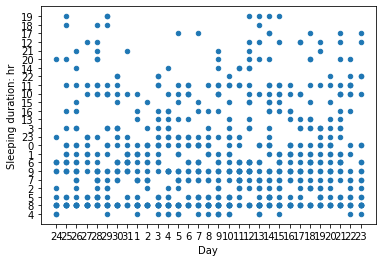

In [10]:
ax1 = DurationSlept.plot.scatter(y='Sleeping duration: hr',
                      x='Day')
DurationSlept.head()

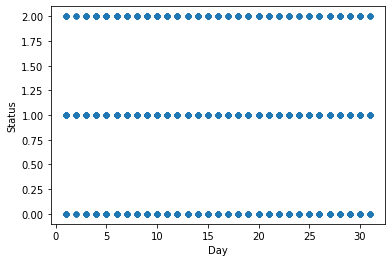

In [11]:
ax1 = bed_data.plot.scatter(x='Day',y='Status',alpha=0.5)

In [15]:
odd_days = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31]
bed_data = bed_data.reset_index()
odd_data = bed_data[bed_data['Day'].isin(odd_days)]
even_data = bed_data[~bed_data['Day'].isin(odd_days)]

X = odd_data.drop(['Sensor_num','Status'], axis = 'columns')
y = odd_data['Status']
print(X.head())
print(y.head())

   index  Day  Month  Year  Hour  Min
0     22   23     10  2017    10   50
1     36   23     10  2017    11   28
2    105   23     10  2017    14   25
3    121   23     10  2017    15   42
4    139   23     10  2017    16   51
0    1
1    1
2    1
3    1
4    1
Name: Status, dtype: object


In [0]:
#svm grid search


In [0]:
def compute_performance(yhat, y):
    # First, get tp, tn, fp, fn
    tp = sum(np.logical_and(yhat == 1, y == 1))
    tn = sum(np.logical_and(yhat == 0, y == 0))
    fp = sum(np.logical_and(yhat == 1, y == 0))
    fn = sum(np.logical_and(yhat == 0, y == 1))

    print(f"tp: {tp} tn: {tn} fp: {fp} fn: {fn}")
    
    # Accuracy
    trainacc = (tp + tn) / (tp + tn + fp + fn)
    
    # Precision
    # "Of the ones I labeled +, how many are actually +?"
    precision = tp / (tp + fp)
    
    # Recall
    # "Of all the + in the data, how many do I correctly label?"
    recall = tp / (tp + fn)    
    
    # Sensitivity
    # "Of all the + in the data, how many do I correctly label?"
    sensitivity = recall
    
    # Specificity
    # "Of all the - in the data, how many do I correctly label?"
    specificity = tn / (fp + tn)
    
    # Print results
    
    print("Acc:",round(trainacc,3),"Rec:",round(recall,3),"Prec:",round(precision,3),
          "Sens:",round(sensitivity,3),"Spec:",round(specificity,3))
    
    # Print CI for accuracy
    # We can use statsmodel's proportion_confint that uses a normal approximation 
    # to th binomial distribution 
    # proportion_confint(count, nobs, alpha=0.05, method='normal')
    print("CI for accuracy: ", proportion_confint(tp + tn, tp + tn + fp + fn ))